# Use Elibitility Trace Actor-Critic to Play Acrobot-v1

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import copy
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.distributions as distributions

logging.basicConfig(level=logging.DEBUG,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('Acrobot-v1')
env.seed(0)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

14:21:37 [INFO] env: <AcrobotEnv<Acrobot-v1>>
14:21:37 [INFO] action_space: Discrete(3)
14:21:37 [INFO] observation_space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
14:21:37 [INFO] reward_range: (-inf, inf)
14:21:37 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 15}
14:21:37 [INFO] _max_episode_steps: 500
14:21:37 [INFO] _elapsed_steps: None
14:21:37 [INFO] id: Acrobot-v1
14:21:37 [INFO] entry_point: gym.envs.classic_control:AcrobotEnv
14:21:37 [INFO] reward_threshold: -100.0
14:21:37 [INFO] nondeterministic: False
14:21:37 [INFO] max_episode_steps: 500
14:21:37 [INFO] _kwargs: {}
14:21:37 [INFO] _env_name: Acrobot


In [3]:
class ElibilityTraceActorCriticAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        self.actor_lambda = 0.9
        self.critic_lambda = 0.9

        self.actor_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,],
                output_size=env.action_space.n, output_activator=nn.Softmax(1))
        self.actor_optimizer = optim.Adam(self.actor_net.parameters(), 0.0001)
        self.actor_trace = copy.deepcopy(self.actor_net)

        self.critic_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[100,], output_size=self.action_n)
        self.critic_optimizer = optim.Adam(self.critic_net.parameters(), 0.0002)
        self.critic_loss = nn.MSELoss()
        self.critic_trace = copy.deepcopy(self.critic_net)

    def build_net(self, input_size, hidden_sizes, output_size,
            output_activator=None):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        net = nn.Sequential(*layers)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []
            self.discount = 1.

            def weights_init(m):
                if isinstance(m, nn.Linear):
                    init.zeros_(m.weight)
                    init.zeros_(m.bias)
            self.actor_trace.apply(weights_init)
            self.critic_trace.apply(weights_init)

    def step(self, observation, reward, done):
        state_tensor = torch.as_tensor(observation, dtype=torch.float).unsqueeze(0)
        prob_tensor = self.actor_net(state_tensor)
        action_tensor = distributions.Categorical(prob_tensor).sample()
        action = action_tensor.numpy()[0]
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
            self.discount *= self.gamma
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, target_weight, evaluate_weight):
        for target_param, evaluate_param in zip(
                target_net.parameters(), evaluate_net.parameters()):
            target_param.data.copy_(evaluate_weight * evaluate_param.data
                    + target_weight * target_param.data)

    def learn(self):
        state, _, _, action, next_state, reward, done, next_action = \
                self.trajectory[-8:]
        state_tensor = torch.as_tensor(state, dtype=torch.float).unsqueeze(0)
        next_state_tensor = torch.as_tensor(state, dtype=torch.float).unsqueeze(0)

        pred_tensor = self.critic_net(state_tensor)
        pred = pred_tensor.detach().numpy()[0, 0]
        next_v_tesnor = self.critic_net(next_state_tensor)
        next_v = next_v_tesnor.detach().numpy()[0, 0]
        target = reward + (1. - done) * self.gamma * next_v
        td_error = target - pred

        # train actor
        pi_tensor = self.actor_net(state_tensor)[0, action]
        logpi_tensor = torch.log(torch.clamp(pi_tensor, 1e-6, 1.))
        self.actor_optimizer.zero_grad()
        logpi_tensor.backward(retain_graph=True)
        for param, trace in zip(self.actor_net.parameters(),
                self.actor_trace.parameters()):
            trace.data.copy_(self.gamma * self.actor_lambda * trace.data + \
                    self.discount * param.grad)
            param.grad.copy_(-td_error * trace)
        self.actor_optimizer.step()

        # train critic
        v_tensor = self.critic_net(state_tensor)[0, 0]
        self.critic_optimizer.zero_grad()
        v_tensor.backward()
        for param, trace in zip(self.critic_net.parameters(),
                self.critic_trace.parameters()):
            trace.data.copy_(self.gamma * self.critic_lambda * trace.data +
                    param.grad)
            param.grad.copy_(-td_error * trace)
        self.critic_optimizer.step()


agent = ElibilityTraceActorCriticAgent(env)

14:21:37 [INFO] ==== train ====
14:21:40 [DEBUG] train episode 0: reward = -500.00, steps = 500
14:21:43 [DEBUG] train episode 1: reward = -500.00, steps = 500
14:21:45 [DEBUG] train episode 2: reward = -500.00, steps = 500
14:21:47 [DEBUG] train episode 3: reward = -346.00, steps = 347
14:21:48 [DEBUG] train episode 4: reward = -149.00, steps = 150
14:21:50 [DEBUG] train episode 5: reward = -311.00, steps = 312
14:21:51 [DEBUG] train episode 6: reward = -323.00, steps = 324
14:21:52 [DEBUG] train episode 7: reward = -184.00, steps = 185
14:21:53 [DEBUG] train episode 8: reward = -143.00, steps = 144
14:21:54 [DEBUG] train episode 9: reward = -225.00, steps = 226
14:21:56 [DEBUG] train episode 10: reward = -207.00, steps = 208
14:21:56 [DEBUG] train episode 11: reward = -171.00, steps = 172
14:21:57 [DEBUG] train episode 12: reward = -123.00, steps = 124
14:21:58 [DEBUG] train episode 13: reward = -208.00, steps = 209
14:21:59 [DEBUG] train episode 14: reward = -188.00, steps = 189
14:

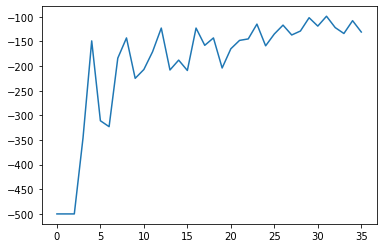

In [4]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-10:]) > -120:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()